In [3]:
import pandas as pd
import boto3
import botocore

import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot



#This is for the initial data load

#BUCKET_NAME = 'sagemaker-us-east-1-023375022819' # replace with your bucket name
#KEY = 'David-Eddy/Fraud/PS_20174392719_1491204439457_log.csv' # replace with your object key

#s3 = boto3.resource('s3')

#try:
#    s3.Bucket(BUCKET_NAME).download_file(KEY,"PS_20174392719_1491204439457_log.csv")
#except botocore.exceptions.ClientError as e:
#    if e.response['Error']['Code'] == "404":
#        print("The object does not exist.")
#    else:
#        raise
        
    

In [1]:
!pwd

/home/ec2-user/SageMaker/amazon-sagemaker-architecting-for-ml/FraudExample


In [4]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.shape

(6362620, 11)

In [7]:
def get_missing_values(df):

    m = {}

    total_rows = df.shape[0]
    
    for h in list(df):
        n_missing = df[h].isna().sum()

        ratio_missing = n_missing / total_rows

        if ratio_missing > .10:
        
            m[h] = "{0:.2f}%".format(ratio_missing * 100)
    
    return m

missing_values = get_missing_values(df)   

In [8]:
missing_values

{}

In [9]:
df["type"].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [110]:
keep_list = ["isFraud", "type", "amount", "nameOrig","oldbalanceOrg","newbalanceOrig","nameDest","oldbalanceDest","newbalanceDest", "isFlaggedFraud"]

reduced_df = df[keep_list]

In [112]:
reduced_df.head()

,isFlaggedFraud,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,0,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,0,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,0,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,0,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

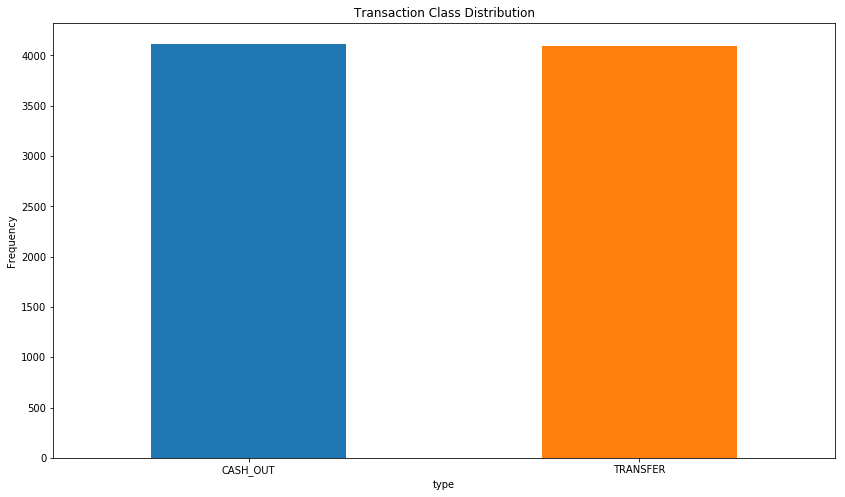

In [113]:


keep_list2 = ["type","isFraud"]
type_df = reduced_df[keep_list2]
type_df = type_df[type_df["isFraud"] == 1]
type_df.groupby(['type']).count()

count_classes = pd.value_counts(type_df["type"], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), ["CASH_OUT","TRANSFER"])
plt.xlabel("type")
plt.ylabel("Frequency");

count_classes


Not surprising that the isFraud Transactions where the ones where money is moving out of an account

CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

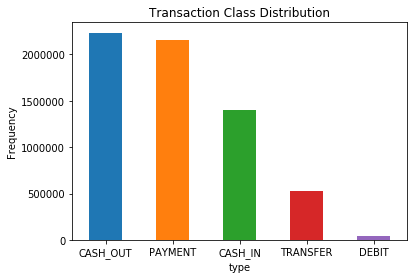

In [13]:
keep_list2 = ["type","isFraud"]
type_df = reduced_df[keep_list2]
type_df = type_df[type_df["isFraud"] == 0]
type_df.groupby(['type']).count()

count_classes = pd.value_counts(type_df["type"], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(5), ["CASH_OUT","PAYMENT","CASH_IN","TRANSFER","DEBIT"])
plt.xlabel("type")
plt.ylabel("Frequency");

count_classes

There are many more cash_out transactions that transfers.   So, transfers has a higher persentage of isFraud.

0    6354407
1       8213
Name: isFraud, dtype: int64

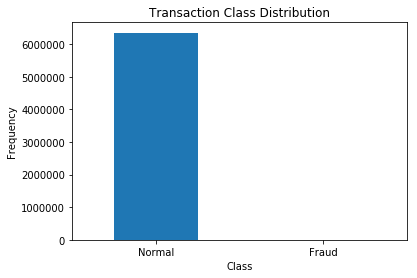

In [14]:
count_classes = pd.value_counts(reduced_df['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency");

count_classes

In [114]:
Fraud = reduced_df[reduced_df["isFraud"] == 1].sort_values(by=["amount"])
Fraud.shape

(8213, 10)

In [115]:
Normal = reduced_df[reduced_df["isFraud"] == 0].sort_values(by=["amount"])
Normal.shape

(6354407, 10)

In [116]:
Normal.amount.describe()


count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [117]:
Normal[Normal["amount"] == Normal.amount.max()]

,isFlaggedFraud,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
3686583,0,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9595.98,92455112.62,0


In [19]:
Normal.amount.head()


4736180    0.01
3027913    0.02
4077303    0.02
2359430    0.02
6002642    0.03
Name: amount, dtype: float64

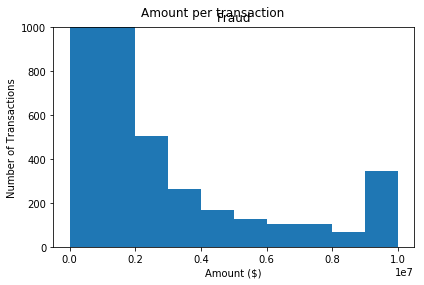

In [20]:
f, (ax1) = plt.subplots(1, 1, sharex=True)
f.suptitle('Amount per transaction')
bins = 10
ax1.hist(Fraud.amount, bins = bins)
ax1.set_title('Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
#plt.xlim((0, 10000))
plt.ylim(0,1000)
plt.tight_layout()

plt.show();

The amounts of fradulent transaction (mean     1.467967e+06)  is much higher than normal transactions. (mean     1.781970e+05)

And notably any thing over 800K was isFraud with 1 exception of $93M.   

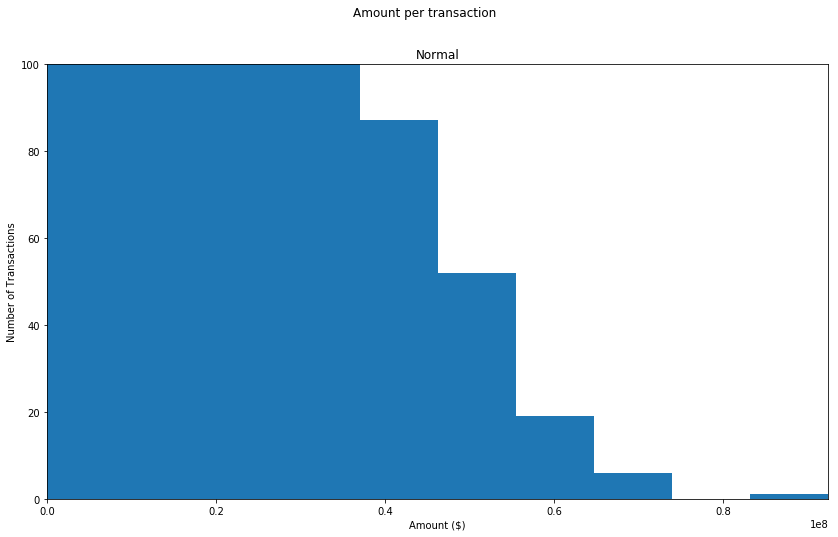

In [124]:
f, (ax2) = plt.subplots(1, 1, sharex=True)


f.suptitle('Amount per transaction')
bins = 10
ax2.hist(Normal.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 92445520))
plt.ylim(0,100)
plt.show();

<b> Hello </b>



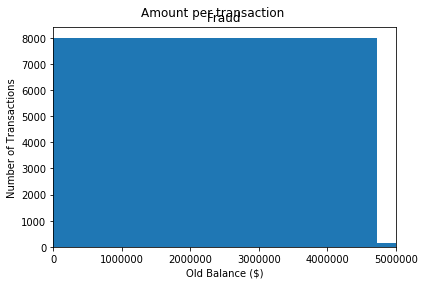

In [22]:
f, (ax1) = plt.subplots(1, 1, sharex=True)
f.suptitle('Amount per transaction')
bins = 50
ax1.hist(Fraud.oldbalanceDest, bins = bins)
ax1.set_title('Fraud')
plt.xlabel('Old Balance ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 5000000))
#plt.ylim(0,1000)
plt.tight_layout()

plt.show();

Didn't see much of anything in the balances as interesting or indicators.

In [25]:
reduced_df.to_csv("reduced_dataset.csv")


In [118]:
model_df = pd.get_dummies(reduced_df, columns = ["type"])

In [29]:
reduced_df.to_csv("model_dataset.csv")

In [132]:
model_df.head()

,isFlaggedFraud,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,1,0
1,0,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,1,0
2,0,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,0,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,0
4,0,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,1,0


In [33]:
Normal[Normal["amount"] == Normal.amount.max()]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
3686583,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9595.98,92455112.62,0


In [34]:
model_df[model_df["amount"] == model_df.amount.max()]

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3686583,92445516.64,C1715283297,0.0,0.0,C439737079,9595.98,92455112.62,0,0,0,0,0,1


In [133]:
model_df2 = model_df

In [134]:
model_df.shape

(6362620, 14)

In [121]:
model_df2.drop(model_df2.index[3686583], inplace=True)

In [122]:
model_df2.shape

(6362618, 13)

In [136]:
model_df30percent = model_df2.head(2000000)

In [140]:
model_df2.to_csv("model_dataset_full.csv")

In [137]:
model_df30percent.head()

,isFlaggedFraud,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,1,0
1,0,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,1,0
2,0,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,0,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,0
4,0,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,1,0


In [108]:
model_df30percent[model_df30percent["isFraud"] == 1].shape

(2036, 13)

In [139]:
print(model_df2.corr())

                isFlaggedFraud    amount  oldbalanceOrg  newbalanceOrig  \
isFlaggedFraud        1.000000  0.012295       0.003835        0.003776   
amount                0.012295  1.000000      -0.002762       -0.007861   
oldbalanceOrg         0.003835 -0.002762       1.000000        0.998803   
newbalanceOrig        0.003776 -0.007861       0.998803        1.000000   
oldbalanceDest       -0.000513  0.294137       0.066243        0.067812   
newbalanceDest       -0.000529  0.459304       0.042029        0.041837   
isFraud               0.044109  0.076688       0.010154       -0.008148   
type_CASH_IN         -0.000842 -0.009621       0.506761        0.527373   
type_CASH_OUT        -0.001168 -0.004376      -0.200899       -0.210977   
type_DEBIT           -0.000128 -0.023379      -0.021450       -0.021872   
type_PAYMENT         -0.001133 -0.197444      -0.189486       -0.193915   
type_TRANSFER         0.005245  0.365896      -0.081593       -0.087355   

                oldbalan

#Hello


based on correlation we decided to keep  amount,  isFlaggedFraud, oldbalanceOrg,type_CASH_IN, type_CASH_OUT,  type_PAYMENT, type_TRANSFER

and thus <b> drop newbalanceOrig, oldbalanceDest, newbalanceDest, type_DEBIT </b>


In [125]:
model_df2.amount.describe()

count    6.362618e+06
mean     1.798461e+05
std      6.027403e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487176e+04
75%      2.087213e+05
max      7.382349e+07
Name: amount, dtype: float64

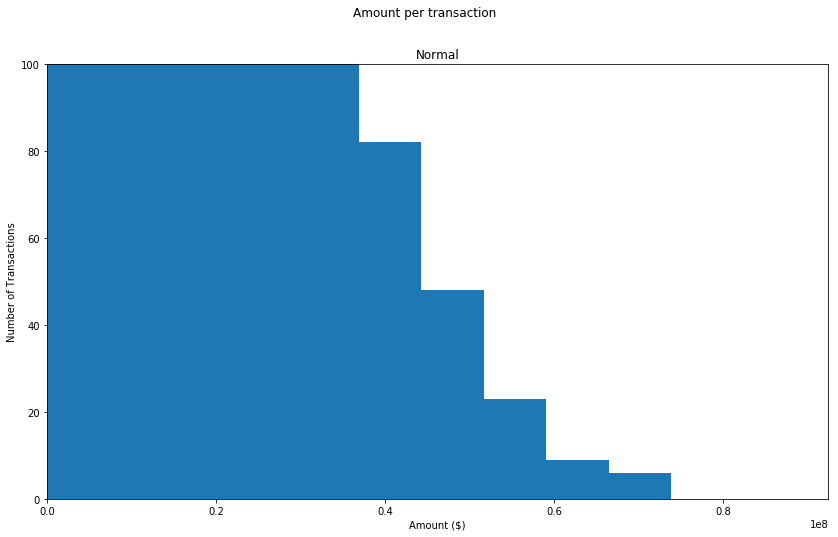

In [126]:
f, (ax2) = plt.subplots(1, 1, sharex=True)


f.suptitle('Amount per transaction')
bins = 10
ax2.hist(model_df2.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 92445520))
plt.ylim(0,100)
plt.show();